# <font color=darkcyan>  Machine Learning in Python </font>

### <font color=darkorange> Random forests & Neural networks...</font>

## 1. <font color=darkred>  Random forests </font>

### <font color=darkred>  Random forests for time series prediction - simulated data </font>

Consider a Markov chain, given by $X_0 = x_0$ for $x_0\in \mathbb{R}^d$ and, for $k\geqslant 0$,
$$
X_{k+1} = \rho X_k + \sigma_X\varepsilon_k\,\,\, [2\pi]\,
$$ 
where $(\epsilon_k)_{k\geqslant 0}$ are i.i.d. standard Gaussian vectors in $\mathbb{R}^d$ $\sim {\sf N}(0,{\bf I}_d)$.

The observation model is
$$ 
Y_k = f(X_k) + \sigma_Y\eta_{k}\,,
$$
where $(\eta_k)_{k\geqslant 0}$ are i.i.d. $\sim N(0,1)$ and
$$
f:\begin{cases}
\mathbb{R}^d\to\mathbb{R}\\
{\bf x} \mapsto \sum_{i=1}^{d}\cos(x_i)
\end{cases}\,.
$$
The objective is to estimate the function $f$ using a training data set to predict the observations associated with the test dataset.

Start with a few imports, in particular the function ``RandomForestRegressor`` of sklearn that enables to apply the random forest algorithm in python.

In [57]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [229]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
%matplotlib inline

The following cell allows me to track your progress and see some of your results. You can use your first name or a  pseudonym if you prefer! 

In [20]:
import requests
exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)
name = input("Name:")
session = 32

Name:A


Define a function that takes as input the size $d$ of the vector $x_0$, the size $n$ of the dataset, the noise levels $\sigma_X$ of the autoregressive model and $\sigma_Y$ of the observed values and the parameter $\rho$ in the autoregressive model.

The function outputs data following the model described above.

In [231]:
# function to sample a dataset 
def sample_data_ar(rho,sigmax,sigmay,n,d):
    X       = np.zeros(shape=(n,d))
    Y       = np.zeros(n)
    epsilon = np.random.normal(loc=0,scale=1,size = X.shape)
    eta     = np.random.normal(loc=0,scale=1,size = n)
    Y[0]    = np.sum(np.cos(X[0,:])) + sigmax*eta[0]
    for k in range(1,n):
        X[k,:] = (rho*X[k-1,:] + sigmax*epsilon[k,:])%(2*np.pi)
        Y[k]   = np.sum(np.cos(X[k,:])) + sigmay*eta[k]
    return X, Y

In [232]:
# set parameters
n = 2000
d = 2

rho    = 0.8
sigmax = 0.1 
sigmay = 0.01 

Matrices X and Y containing data simulated according to the observation model described above may now be computed.

In this simulated toy model, the values of the hidden Markov chain $X_k$ are available in the matrix $X$. 
In practice, only the vector $Y$ is observed (the values of $X_k$ must be estimated sequentially).

In [239]:
# sample data  
X, Y = sample_data_ar(rho,sigmax,sigmay,n,d)

To evaluate different algorithms, the dataset is decomposed into training and test data.
In this type of time series analysis, the training data are the first values of $Y_k$ and the test are the last one. This corresponds to situations where one wants to predict future values of $Y$ given historical data.
This is somehow different form the i.i.d. case where taining and test data are chosen randomly using the function ``sklearn.model_selection.train_test_split``

In [240]:
# split variables and observations, using 90% of the data set to estimate f 
import pandas as pd
if d==4:
    df = pd.DataFrame(data = X, columns = ['X1', 'X2', 'X3', 'X4'])
if d==2:
    df = pd.DataFrame(data = X, columns = ['X1', 'X2'])
df['Y'] = Y

nb_data_train = int(0.95*n)
nb_diff       = n-nb_data_train
df.head()
X_train = df.iloc[0:nb_data_train,:-1] 
X_test  = df.iloc[-nb_diff:,0:-1]
X_train.head()
Y_train = df.iloc[0:nb_data_train,-1] 
Y_test  = df.iloc[-nb_diff:,-1]

We can visualize the data in the following graph, with the colors corresponding to the value of Y.

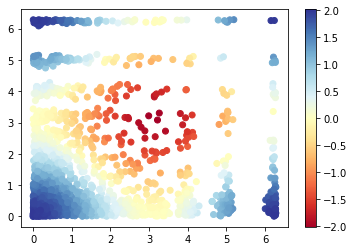

In [241]:
plt.scatter(X[:,0],X[:,1], c=Y, cmap=plt.cm.RdYlBu)
plt.colorbar()


At first, we can perform regression using a Regression Tree:

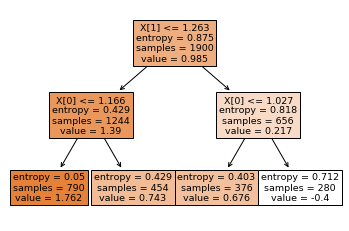

'syntehtic_data_dec_tree.pdf'

In [242]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split

clf = DecisionTreeRegressor(max_depth=2, random_state=0)
clf.fit(X_train.values, Y_train.values)

plot_tree(clf, filled=True)
plt.show()

import graphviz 
dot_data = export_graphviz(clf, filled=True, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("syntehtic_data_dec_tree") 

We can visualize the frontiers on the first 2 dimensions using the ```contourf``` function

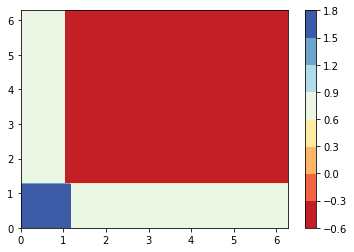

In [243]:
if d==2:
    plot_step = 0.02
    x_min, x_max = 0, 2*np.pi
    y_min, y_max = 0, 2*np.pi
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.colorbar()
    plt.show()

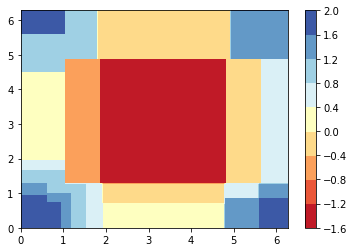

In [244]:
if d==2:
    clf = DecisionTreeRegressor(max_depth=5, random_state=0)
    clf.fit(X_train.values, Y_train.values)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.colorbar()
    plt.show()

#### Regression Forest

A first random forest prediction can be performed. 
``rf`` is the random forest function of sklearn when the number of trees in the forest is set to ``n\_trees``.
The forest is estimated using the training data ``X\_train`` and ``Y\_train`` and the values of $Y$ in the test set are compared to those predicted by the algorithm.
The mean-squared error between these quantities is also displayed.

In [245]:
# We change parmeters for the following, incresing dimension to 4
# set parameters
n = 2000
d = 4

rho    = 0.1
sigmax = 0.1 
sigmay = 0.01 

# sample data  
X, Y = sample_data_ar(rho,sigmax,sigmay,n,d)

# split variables and observations, using 90% of the data set to estimate f 
if d==4:
    df = pd.DataFrame(data = X, columns = ['X1', 'X2', 'X3', 'X4'])
if d==2:
    df = pd.DataFrame(data = X, columns = ['X1', 'X2'])
df['Y'] = Y

nb_data_train = int(0.95*n)
nb_diff       = n-nb_data_train
df.head()
X_train = df.iloc[0:nb_data_train,:-1] 
X_test  = df.iloc[-nb_diff:,0:-1]
X_train.head()
Y_train = df.iloc[0:nb_data_train,-1] 
Y_test  = df.iloc[-nb_diff:,-1]

mse is 1.78e-03


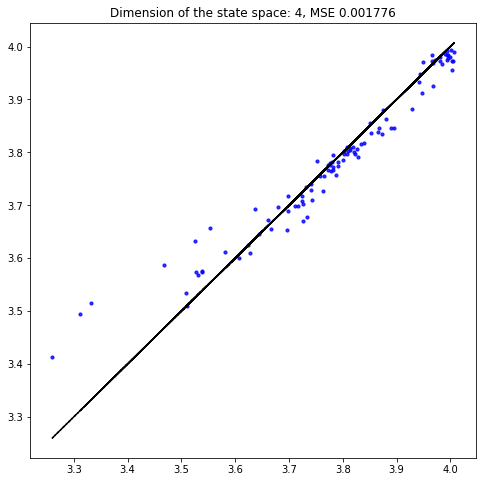

In [246]:
# number of trees in the forest for an elementary random forest estimate
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)
print('mse is', "%.2e" %mse)

plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf, color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='k', linestyle = 'dashed')
plt.show()

The predictions seem reasonable but it may be that these predictions are very accurate at first and then that the errors accumulate over time.
To test if this is the case, plot the values of $Y$ in the test set (true and predicted) as functions of the time from the last training time.

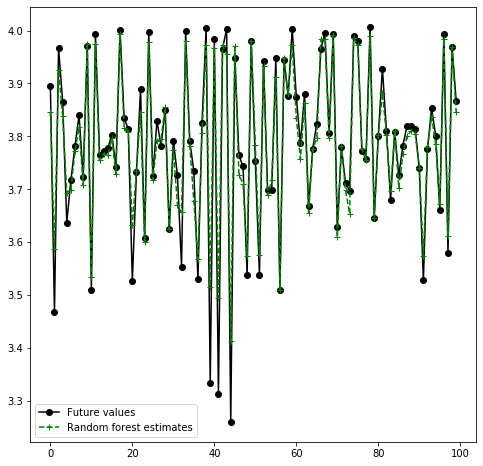

In [247]:
plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))


To improve this first prediction, the different parameters of the random forest algorithm may be tuned. For example, an increase of the number of trees in the forest reduced the varaince of the Monte Carlo estimate.

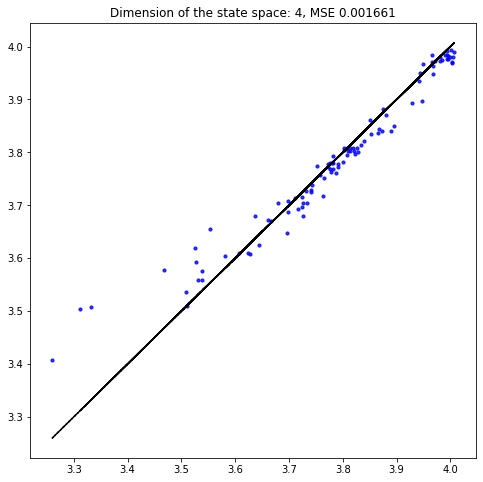

In [248]:
# number of trees in the forest
n_trees = 500
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)

plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf, color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='k', linestyle = 'dashed')

Note that this increases substancially the computational time although predictions seem equally relevant.

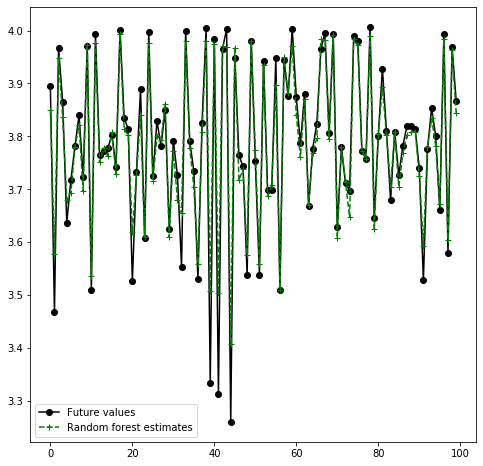

In [250]:
plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))

The objective is now to improve the algorithm using a cross-validation scheme to estimate the best value of these parameters. It is useful to look at the parameters used by default in the algorithm here:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Set a grid of parameters that will be tested by the cross-validation procedure.

In [251]:
# with RandomizedSearchCVCreate, a grid of tuning parameters is built
# then a random search will be performed to test which parameter values yield the best 
# random forest estimate (see below).
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features is the number of dimension considered to select the best split (the dimension along which a cell is cut)
max_features = ['log2', 'sqrt']
# The maximum depth of the tree corresponds to the maximum number of levels of the tree. 
# If not given, splits are performed until all cells contain less than min_samples_split samples.
max_depth = np.arange(5,100,5)
# min_samples_split is the minimum number of samples in a cell to allow a split.
min_samples_split = [2, 3, 4, 5, 6, 7, 8]
# A split is considered in the tree if it leaves at least min_samples_leaf training samples in each 
# subcell obtained after the spliting process.
min_samples_leaf = [1, 2, 3, 4]
# if bootstrap is true all the training dataset is used to build each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95]),
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Exploring all parameters combinations in this grid would be computationally prohibitive. 
An efficient alternative is to compare parameters chosen at random in the grid.

In [252]:
rf = RandomForestRegressor()
# Random search among  all parameters (the number of possible combination is given. It is not a complete grid search !!!).
# search across n_iter = 100 different combinations with a default 3-fold cross validation.
rf_random = RandomizedSearchCV(estimator=rf,
                               param_distributions=random_grid,
                               n_iter=10,
                               cv=3,
                               verbose=10,
                               n_jobs=-1)

rf_random.fit(X_train, Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  19 out of  30 | elapsed:    8.8s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    9.2s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:   13.6s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   14.5s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [253]:
# display the best parameters
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 45,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 1600}

In [254]:
# build the best explored random forest
best_random = rf_random.best_estimator_

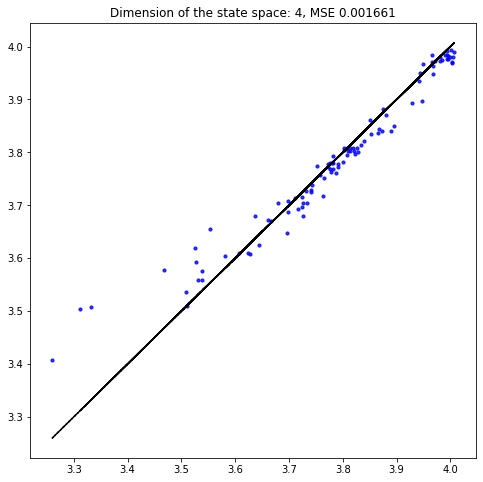

In [255]:
plt.figure(1,figsize=(8,8))
plt.title('Dimension of the state space: %d, MSE %f' %(d,mse))
plt.scatter(Y_test,y_pred_rf, color='b', s = 10, alpha = 0.8)
plt.plot(Y_test,Y_test,color='k', linestyle = 'dashed')

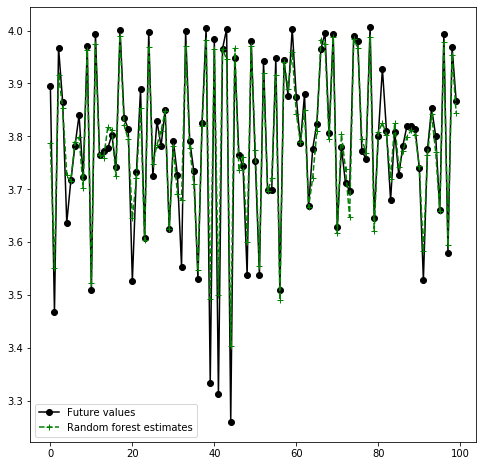

In [256]:
# compute predictions usting test data and associated mean square error
y_pred_rf = rf_random.predict(X_test)
mse       = mean_squared_error(Y_test,y_pred_rf)
plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future values','Random forest estimates'))

### <font color=darkred> Random forests for time series prediction - Inflation prediction </font>

In [16]:
! wget -q https://raw.githubusercontent.com/adieulev/Certificate-data-science/master/Data/BRinf

dyld: Library not loaded: /usr/local/opt/openssl/lib/libssl.1.0.0.dylib
  Referenced from: /usr/local/bin/wget
  Reason: image not found


In [17]:
# In this section, random forests are used to predic the Brazilian inflation based on
# many observed variables, see https://github.com/gabrielrvsc/HDeconometrics/
import pandas as pd
df = pd.read_csv('BRinf')
df.head()

,Unnamed: 0,Brazil CPI IPCA MoM,FGV Brazil General Prices IGP-,FGV Brazil General Prices IGP-.1,FGV Brazil General Prices IGP-.2,FGV Brazil General Prices IGP-.3,Brazil CPI IPCA Median Market,Brazil Total Electricity Consu,Brazil Industrial Electricity,BofA Merrill Lynch Economic Co,...,X5t.12,X5t.13,fmed2,fmean,fmean2,fdp,lfmed2,lfmean,lfmean2,lfdp
0,2003-01-31,2.25,2.33,2.17,5.816,2.29,11.56,25422.0,-359,-1.47,...,0.80,0.68,4.0000,1.96,3.8416,0.18,1.3225,1.15,1.3225,0.24
1,2003-02-28,1.57,2.28,1.59,4.351,2.42,10.95,25163.0,-303,-1.21,...,0.68,0.48,2.5600,1.60,2.5600,0.26,0.7569,0.91,0.8281,0.27
2,2003-03-31,1.23,1.53,1.66,4.593,1.58,9.58,24960.0,115,-0.35,...,0.55,0.50,0.8836,0.93,0.8649,0.13,0.4900,0.73,0.5329,0.17
3,2003-04-30,0.97,0.92,0.41,1.173,1.24,8.88,25284.0,93,-0.15,...,0.45,0.78,1.0000,0.97,0.9409,0.14,0.2500,0.52,0.2704,0.18
4,2003-05-31,0.61,-0.26,-0.67,-1.860,0.02,8.22,24785.0,285,-0.47,...,0.60,0.43,0.2500,0.50,0.2500,0.10,0.3025,0.55,0.3025,0.15


In [14]:
# number of observations, number of variables
df.shape

(156, 93)

The function ``pandas.DataFrame.corr`` may be used to compute the pairwise correlations between columns (variables and inflation). These correlations can be displayed using ``sns.heatmap`` to highlight highly correlated variables (and those likely to have an impact on the inflation).

See ``feature_importances_`` below for a first try at (relevant) variable selection.

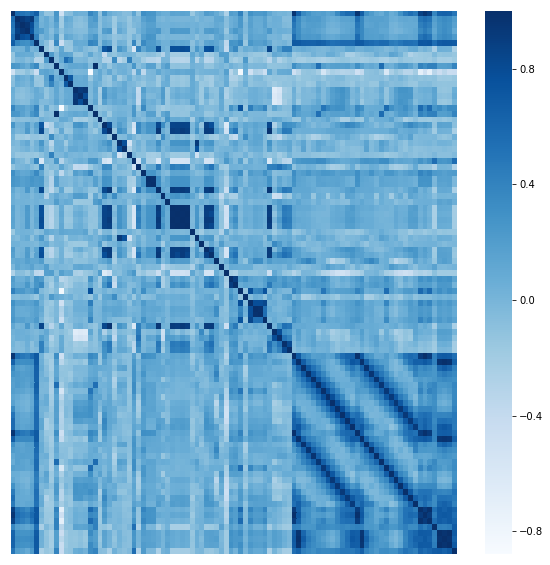

In [13]:
import seaborn as sns
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corr, xticklabels = False, yticklabels = False, cmap = 'Blues', ax = ax)

In [14]:
corr.head()

,Brazil CPI IPCA MoM,FGV Brazil General Prices IGP-,FGV Brazil General Prices IGP-.1,FGV Brazil General Prices IGP-.2,FGV Brazil General Prices IGP-.3,Brazil CPI IPCA Median Market,Brazil Total Electricity Consu,Brazil Industrial Electricity,BofA Merrill Lynch Economic Co,CNI Brazil Manufacture Industr,...,X5t.12,X5t.13,fmed2,fmean,fmean2,fdp,lfmed2,lfmean,lfmean2,lfdp
Brazil CPI IPCA MoM,1.000000,0.564057,0.513079,0.472865,0.548028,0.666126,0.051693,-0.138035,-0.128571,0.265466,...,0.548735,0.468353,0.876131,0.960011,0.877122,0.378376,0.632513,0.646564,0.631671,0.500115
FGV Brazil General Prices IGP-,0.564057,1.000000,0.931098,0.875071,0.937050,0.383307,0.015717,0.091837,-0.013777,0.234420,...,0.099243,0.118357,0.496675,0.557056,0.501341,0.198352,0.298803,0.345757,0.311183,0.206675
FGV Brazil General Prices IGP-.1,0.513079,0.931098,1.000000,0.950262,0.792862,0.322426,0.030985,0.083818,0.004757,0.151959,...,0.093295,0.096065,0.428282,0.487584,0.436533,0.161159,0.279579,0.324037,0.288390,0.164378
FGV Brazil General Prices IGP-.2,0.472865,0.875071,0.950262,1.000000,0.735705,0.301127,0.208221,0.073154,-0.067722,0.075466,...,0.088300,0.119306,0.360302,0.451189,0.367995,0.125552,0.276022,0.327440,0.280982,0.096484
FGV Brazil General Prices IGP-.3,0.548028,0.937050,0.792862,0.735705,1.000000,0.411856,-0.002718,0.080790,-0.021884,0.248427,...,0.111940,0.138191,0.499192,0.569468,0.507088,0.183621,0.316816,0.356699,0.330572,0.228943


In [260]:
nb_data_train = 140
nb_diff       = df.shape[0]-nb_data_train
# inflation observations
Y_train = df.iloc[0:nb_data_train,1] 
Y_test  = df.iloc[-nb_diff:,1] 
Y_test.head()

140    0.57
141    0.42
142    0.51
143    0.78
144    1.24
Name: Brazil CPI IPCA MoM, dtype: float64

In [261]:
# other variables
X_train = df.iloc[0:nb_data_train,2:] 
X_test  = df.iloc[-nb_diff:,2:] 
X_test.head()

,FGV Brazil General Prices IGP-,FGV Brazil General Prices IGP-.1,FGV Brazil General Prices IGP-.2,FGV Brazil General Prices IGP-.3,Brazil CPI IPCA Median Market,Brazil Total Electricity Consu,Brazil Industrial Electricity,BofA Merrill Lynch Economic Co,CNI Brazil Manufacture Industr,CNI Brazil Manufacture Industr.1,...,X5t.12,X5t.13,fmed2,fmean,fmean2,fdp,lfmed2,lfmean,lfmean2,lfdp
140,0.20,0.02,0.110,0.31,6.34,38551.0,580,-0.22,-0.1,81.8,...,0.35,0.41,0.1849,0.43,0.1849,0.04,0.2500,0.49,0.2401,0.05
141,0.28,0.59,3.158,0.02,6.38,38798.0,-266,-0.63,0.3,82.3,...,0.40,0.53,0.2500,0.50,0.2500,0.04,0.3249,0.58,0.3364,0.05
142,0.98,1.14,6.098,0.82,6.57,40100.0,61,-0.76,-0.6,82.6,...,0.52,0.64,0.3025,0.59,0.3481,0.05,0.5476,0.72,0.5184,0.08
143,0.62,0.38,2.089,0.98,6.67,40950.0,327,-1.48,-0.1,82.0,...,0.64,0.71,0.4900,0.75,0.5625,0.05,0.9409,0.97,0.9409,0.12
144,0.76,0.67,3.672,0.42,7.01,39673.0,-773,-0.82,-0.2,78.6,...,0.72,0.69,1.9600,1.18,1.3924,0.11,1.0201,0.99,0.9801,0.16


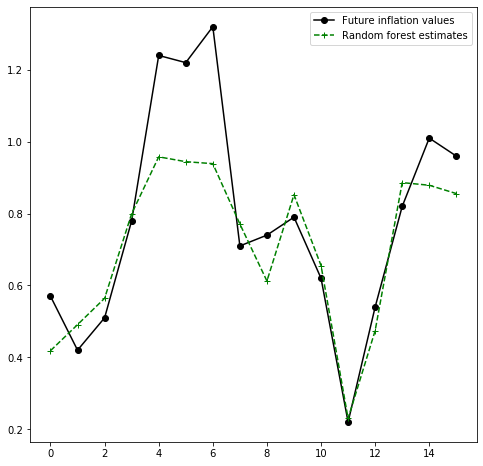

In [264]:
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test)

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))

In [265]:
# Many variables are used for the inflation prediction while very few observations are available.
# Selecting the most valuable variables is an alternativ to learn a simpler models
# This is obtained in Python with rf.feature_importances_

Text(0.5, 1.0, 'Feature importances')

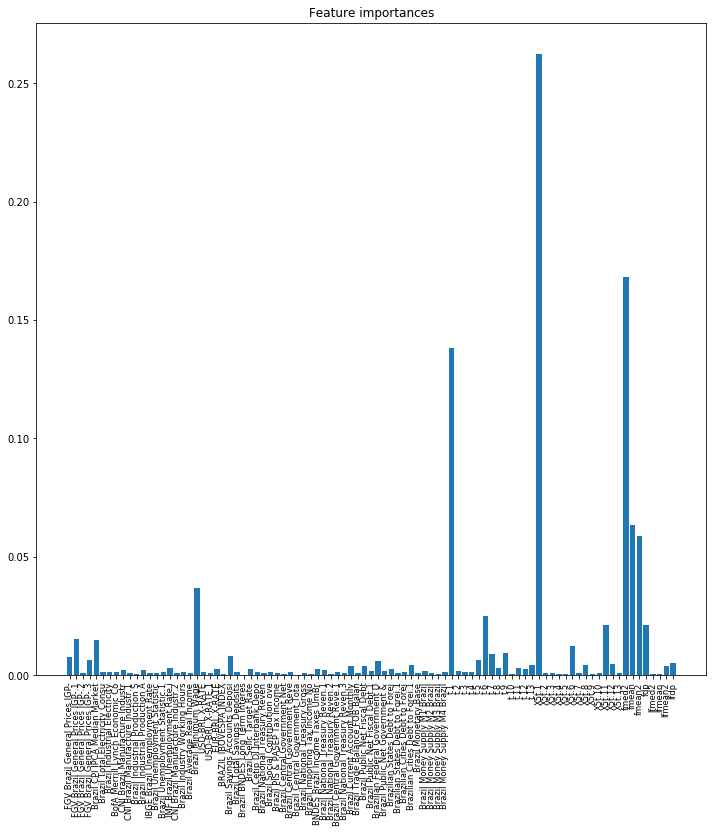

In [266]:
plt.figure(1,figsize=(12,12))
plt.bar(list(df)[2:93],rf.feature_importances_,align='center')
plt.xticks(range(len(list(df)[2:93])),list(df)[2:93],rotation=90,size='small')
plt.title('Feature importances')

In [28]:
# RandomForestClassifier and RandomForestRegressor use the gini importance mechanism as a measure of the 
# fetaures importance. The mean decrease in impurity importance of a 
# feature is computed by measuring the impact of a variable on the variance of the prediction,
# see https://papers.nips.cc/paper/4928-understanding-variable-importances-in-forests-of-randomized-trees.pdf

In [267]:
# collect the indices of the features with highest importance.
nb_features_to_keep = 10
ind = rf.feature_importances_.argsort()[-nb_features_to_keep:]
X_train.iloc[:,ind]

,FGV Brazil General Prices IGP-.1,fdp,X5t.11,t.6,Brazil Minimum Wage,fmean2,fmean,t.1,fmed2,X5t.1
0,2.17,0.18,0.81,0.82,200,3.8416,1.96,2.00,4.0000,2.10
1,1.59,0.26,0.82,1.47,200,2.5600,1.60,1.60,2.5600,1.65
2,1.66,0.13,0.68,0.80,200,0.8649,0.93,0.94,0.8836,0.95
3,0.41,0.14,0.63,0.60,200,0.9409,0.97,1.00,1.0000,1.10
4,-0.67,0.10,0.45,0.58,240,0.2500,0.50,0.50,0.2500,0.50
5,-0.70,0.17,0.63,0.60,240,0.0289,0.17,0.10,0.0100,0.10
6,-0.20,0.28,0.50,0.50,240,0.1521,0.39,0.30,0.0900,0.20
7,0.62,0.12,0.55,0.60,240,0.1296,0.36,0.34,0.1156,0.29
8,1.05,0.09,0.65,0.50,240,0.4624,0.68,0.70,0.4900,0.70
9,0.44,0.08,0.50,0.40,240,0.2601,0.51,0.50,0.2500,0.50


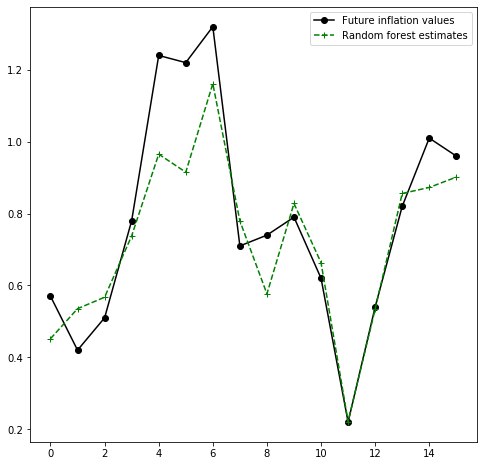

In [268]:
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train.iloc[:,ind],Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test.iloc[:,ind])

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))

<img src="./PCA_cor.png" width="500" height="700">

In [31]:
# plot the MSE as a function of the numbers of variables used to estimate the function f
d_max = 60
MSE   = []
rf    = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train,Y_train)
for d in range(2,d_max): 
    rfd = RandomForestRegressor(n_estimators = n_trees)
    ind = rf.feature_importances_.argsort()[-d:]
    rfd.fit(X_train.iloc[:,ind],Y_train)
    # compute predictions usting test data and associated mean square error
    y_pred_rf = rfd.predict(X_test.iloc[:,ind])
    MSE = np.append(MSE,mean_squared_error(Y_test,y_pred_rf))

Text(0, 0.5, 'Mean square error on the test data set')

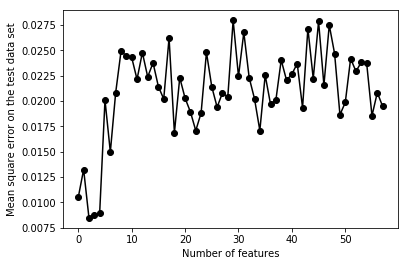

In [32]:
#plt.figure(1,figsize=(8,8))
plt.plot(MSE,marker='o',color='k')
plt.xlabel('Number of features')
plt.ylabel('Mean square error on the test data set')

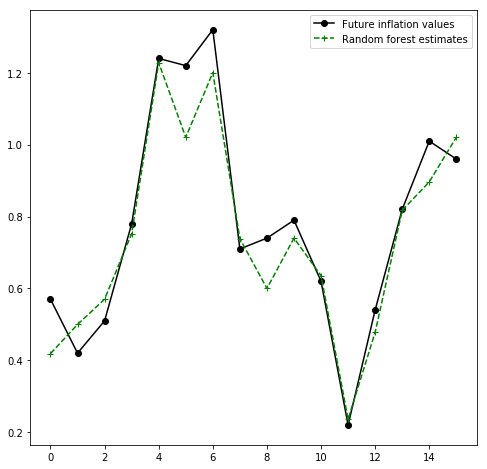

In [33]:
# collect the indices of the features with highest importance.
nb_features_to_keep = 4
ind = rf.feature_importances_.argsort()[-nb_features_to_keep:]
X_train.iloc[:,ind]
n_trees = 100
rf      = RandomForestRegressor(n_estimators = n_trees)
rf.fit(X_train.iloc[:,ind],Y_train)

# compute predictions usting test data and associated mean square error
y_pred_rf = rf.predict(X_test.iloc[:,ind])

plt.figure(1,figsize=(8,8))
plt.plot(Y_test.values,marker='o',color='k')
plt.plot(y_pred_rf,'g--',marker='+')
plt.legend(labels=('Future inflation values','Random forest estimates'))

In [34]:
# you may add here a cross validation procedure using RandomizedSearchCV or GridSearchCV
# to select the best parameters (and compare the mean square error with what you obtain above).